In [12]:
# pip install langgraph==1.0.9 langchain==1.2.10 openai python-dotenv langchain-openai langchain-core langchain-anthropic

In [13]:
import os
from dotenv import load_dotenv

load_dotenv()

OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
ANTHROPIC_API_KEY = os.getenv("ANTHROPIC_API_KEY")

In [14]:
from pydantic import BaseModel, Field
from typing import TypedDict, Optional, List
from langgraph.graph import StateGraph, END
from langchain_openai import ChatOpenAI
from langchain_anthropic import ChatAnthropic
from langchain_core.messages import HumanMessage, SystemMessage

from langgraph.checkpoint.memory import MemorySaver

from langgraph.types import interrupt
from langchain_core.runnables.history import RunnableWithMessageHistory
from langchain_core.chat_history import InMemoryChatMessageHistory

In [15]:
# -----------------------
# Debate Output Schemas
# -----------------------

class DebateOption(BaseModel):
    title: str
    description: str


class DebateOptionsOutput(BaseModel):
    options: List[DebateOption]


class DebateSummary(BaseModel):
    side_a_points: List[str]
    side_b_points: List[str]
    tensions: List[str]

# -----------------------
# Writer Chat Memory Store
# -----------------------
writer_store = {}
def get_writer_session_history(session_id: str):
    if session_id not in writer_store:
        writer_store[session_id] = InMemoryChatMessageHistory()
    return writer_store[session_id]

writer_base_llm = ChatOpenAI(
    model="gpt-5-2",
    temperature=0.7,
    api_key=OPENAI_API_KEY
)
writer_llm = RunnableWithMessageHistory(
    writer_base_llm,
    get_writer_session_history,
    input_messages_key="input",
)

# -----------------------
# Blog State Schema
# -----------------------

class BlogState(BaseModel):
    # Raw + cleaned input
    brain_dump_raw: Optional[str] = None
    brain_dump_cleaned: Optional[str] = None

    reconstruct_scene: Optional[str] = None

    debate_options: List[DebateOption] = Field(default_factory=list)
    selected_debate_option: Optional[str] = None

    debate_full: Optional[str] = None
    debate_summary: Optional[DebateSummary] = None

    story_arc_outline: Optional[str] = None

    voice_fingerprint: Optional[str] = None

    current_draft: Optional[str] = None
    judge_feedback: Optional[str] = None

    # Used for user feedback in revision loop
    user_input: Optional[str] = None

In [16]:
# 1. Brain Dump Cleaner
def clean_brain_dump(state: BlogState):
    llm = ChatOpenAI(
        model="gpt-5-mini", 
        temperature=0.7, 
        api_key=OPENAI_API_KEY
    )

    prompt = f"""
    [CLEANER PROMPT PLACEHOLDER]

    TEXT:
    {state.brain_dump_raw}
    """

    response = llm.invoke(prompt)

    state.brain_dump_cleaned = response.content
    return state

# 2. Memory Reconstruction
def reconstruct_memory(state: BlogState):
    llm = ChatAnthropic(
        model="claude-sonnet-4-6",
        temperature=0.7,
        api_key=ANTHROPIC_API_KEY
    )

    prompt = f"""
    [RECONSTRUCTION PROMPT PLACEHOLDER]

    TEXT:
    {state.brain_dump_cleaned}
    """

    response = llm.invoke(prompt)

    state.reconstruct_scene = response.content
    return state

# 3. Debate Options
def generate_debate_options(state: BlogState):
    llm = ChatOpenAI(
        model="gpt-5-mini",
        temperature=0.7,
        api_key=OPENAI_API_KEY
    )

    structured_llm = llm.with_structured_output(DebateOptionsOutput)

    prompt = f"""
    [DEBATE OPTIONS PROMPT PLACEHOLDER]

    TEXT:
    {state.brain_dump_cleaned}
    """

    result: DebateOptionsOutput = structured_llm.invoke(prompt)

    state.debate_options = result.options

    return interrupt(state)   


# 4. Debate Generator
def generate_debate(state: BlogState):
    llm = ChatAnthropic(
        model="claude-sonnet-4-6",
        temperature=0.7,
        api_key=ANTHROPIC_API_KEY
    )

    prompt = f"""
    [DEBATE GENERATION PROMPT PLACEHOLDER]

    Selected Topic:
    {state.selected_debate_option}
    """

    response = llm.invoke(prompt)

    state.debate_full = response.content

    with open("debate_full.md", "w") as f:
        f.write(state.debate_full)

    return state

# 5. Debate Distiller
def distill_debate(state: BlogState):
    llm = ChatOpenAI(
        model="gpt-5-mini", 
        temperature=0.7, 
        api_key=OPENAI_API_KEY
    )

    structured_llm = llm.with_structured_output(DebateSummary)

    prompt = f"""
    [DEBATE DISTILLER PROMPT PLACEHOLDER]

    TEXT:
    {state.debate_full}
    """

    result: DebateSummary = structured_llm.invoke(prompt)

    state.debate_summary = result

    with open("debate_summary.md", "w") as f:
        f.write(result.model_dump_json(indent=2))

    return state

# 6. Story Arc Generator
def generate_story_arc(state: BlogState):
    llm = ChatAnthropic(
        model="claude-sonnet-4-6",
        temperature=0.7,
        api_key=ANTHROPIC_API_KEY
    )

    prompt = f"""
    [STORY ARC PROMPT PLACEHOLDER]

    Brain Dump:
    {state.brain_dump_cleaned}

    Scene:
    {state.reconstruct_scene}

    Debate Summary:
    {state.debate_summary.model_dump()}
    """

    response = llm.invoke(prompt)

    state.story_arc_outline = response.content
    return interrupt(state)

# 7. Draft Writer
def write_draft(state: BlogState, config):
    prompt = f"""
    [WRITER PROMPT PLACEHOLDER]

    VOICE:
    {state.voice_fingerprint}

    SCENE:
    {state.reconstruct_scene}

    STORY ARC:
    {state.story_arc_outline}

    DEBATE SUMMARY:
    {state.debate_summary.model_dump()}
    """

    session_id = config["configurable"]["thread_id"]

    response = writer_llm.invoke(
        {"input": prompt},
        config={"configurable": {"session_id": session_id}}
    )

    state.current_draft = response.content
    return state

# 8. Judge
def judge_draft(state: BlogState):
    llm = ChatAnthropic(
        model="claude-sonnet-4-6",
        temperature=0.7,
        api_key=ANTHROPIC_API_KEY
    )

    prompt = f"""
    [JUDGE PROMPT PLACEHOLDER]

    VOICE FILE:
    {state.voice_fingerprint}

    BLOG:
    {state.current_draft}
    """

    response = llm.invoke(prompt)

    state.judge_feedback = response.content
    return interrupt(state)

# 9. Revision Node
def revise_draft(state: BlogState, config):
    prompt = f"""
    [REVISION PROMPT PLACEHOLDER]

    VOICE:
    {state.voice_fingerprint}

    USER FEEDBACK:
    {state.user_input}
    """

    session_id = config["configurable"]["thread_id"]

    response = writer_llm.invoke(
        {"input": prompt},
        config={"configurable": {"session_id": session_id}}
    )

    state.current_draft = response.content
    return state

In [17]:
workflow = StateGraph(BlogState)

workflow.add_node("clean", clean_brain_dump)
workflow.add_node("reconstruct", reconstruct_memory)
workflow.add_node("debate_options", generate_debate_options)
workflow.add_node("debate", generate_debate)
workflow.add_node("distill", distill_debate)
workflow.add_node("story_arc", generate_story_arc)
workflow.add_node("write", write_draft)
workflow.add_node("judge", judge_draft)
workflow.add_node("revise", revise_draft)

## Add connections
workflow.set_entry_point("clean")

workflow.add_edge("clean", "reconstruct")
workflow.add_edge("reconstruct", "debate_options")
workflow.add_edge("debate_options", "debate")
workflow.add_edge("debate", "distill")
workflow.add_edge("distill", "story_arc")
workflow.add_edge("story_arc", "write")
workflow.add_edge("write", "judge")

def revision_router(state: BlogState):
    if state.user_input == "approve":
        state.user_input = None
        return END
    return "revise"


workflow.add_conditional_edges(
    "judge",
    revision_router,
    {
        "revise": "revise",
        END: END,
    },
)

workflow.add_edge("revise", "judge")

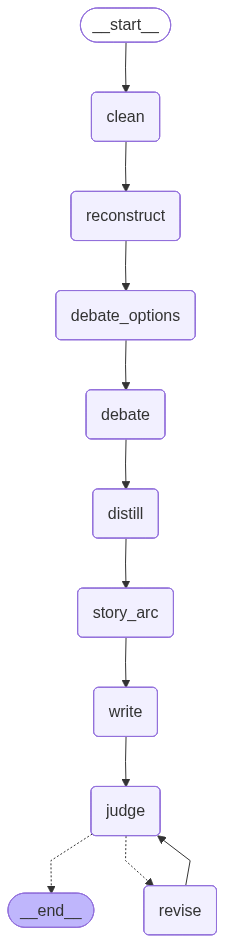

In [18]:
# Compile withmemory
checkpointer = MemorySaver()
app = workflow.compile(checkpointer=checkpointer)
app

In [ ]:
# -----------------------
# Load input files
# -----------------------

with open("brain_dump.md", "r", encoding="utf-8") as f:
    brain_dump_text = f.read()

with open("voice.md", "r", encoding="utf-8") as f:
    voice_text = f.read()

# -----------------------
# Create Initial State
# -----------------------
initial_state = BlogState(
    brain_dump_raw=brain_dump_text,
    voice_fingerprint=voice_text
)

config = {"configurable": {"thread_id": "blog-thread-1"}}
result = app.invoke(initial_state, config=config)

### After selecting debate options

In [ ]:
state.selected_debate_option = "Logging is not debugging"
# state.selected_debate_option = state.debate_options[1].title
result = app.invoke(state, config=config)

### After modifying story arc

In [ ]:
state.story_arc_outline = "updated arc"
# state.user_input = "approve"
app.invoke(state, config=config)

### Modify draft
check the current draft and the feedback

In [ ]:
state.user_input = "Make second paragraph sharper"
# state.user_input = "approve"  
app.invoke(state, config=config)